In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.models import Sequential
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D

In [ ]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [ ]:
import os
import pandas as pd

healthy_dirs = [
    r'/content/drive/My Drive/Colab Notebooks/Osteoporosis/N'
]


osteoporosis_dirs = [
    r'/content/drive/My Drive/Colab Notebooks/Osteoporosis/O'
]
filepaths = []
labels = []
dict_lists = [healthy_dirs, osteoporosis_dirs]
class_labels = ['Healthy', 'Osteoporosis']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
knee_osteoporosis_data = pd.concat([Fseries, Lseries], axis=1)
knee_osteoporosis_df = pd.DataFrame(knee_osteoporosis_data)
print(knee_osteoporosis_df.head())
print(knee_osteoporosis_df["labels"].value_counts())

                                           filepaths   labels
0  /content/drive/My Drive/Colab Notebooks/Osteop...  Healthy
1  /content/drive/My Drive/Colab Notebooks/Osteop...  Healthy
2  /content/drive/My Drive/Colab Notebooks/Osteop...  Healthy
3  /content/drive/My Drive/Colab Notebooks/Osteop...  Healthy
4  /content/drive/My Drive/Colab Notebooks/Osteop...  Healthy
labels
Healthy         372
Osteoporosis    372
Name: count, dtype: int64


In [ ]:
knee_osteoporosis_df.shape

(744, 2)

In [ ]:
train_images, test_images = train_test_split(knee_osteoporosis_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(knee_osteoporosis_df, test_size=0.2, random_state=42)

In [ ]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(595, 2)
(224, 2)
(149, 2)
(520, 2)


In [ ]:
#to get tags
num_classes=2
print(num_classes)
print(len(train_images),"Train images")
print(len(test_images),"Test images")

2
520 Train images
224 Test images


In [ ]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=4,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )

Found 595 validated image filenames belonging to 2 classes.
Found 224 validated image filenames belonging to 2 classes.
Found 149 validated image filenames belonging to 2 classes.


In [ ]:
classes=list(train.class_indices.keys())
print (classes)

['Healthy', 'Osteoporosis']


In [ ]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

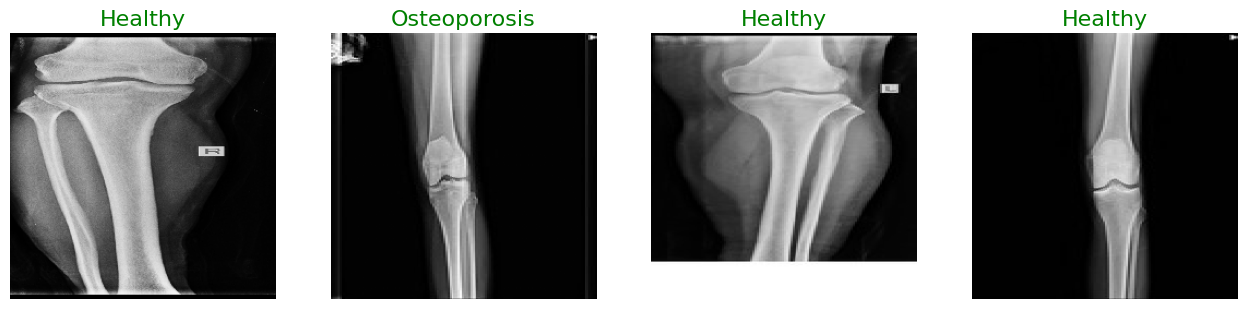

In [ ]:
show_knee_images(train)

#### **1.1 VGG16 Modeli**

In [ ]:
def create_Base_model_from_VGG16():
    model = VGG16(
        weights = "imagenet",
        include_top=False,
        input_shape = (224,224, 3) # goruntu boyutu
        )
    for layer in model.layers:
      layer.trainable = False
    return model
create_Base_model_from_VGG16().summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
def add_custom_layers():
    model = create_Base_model_from_VGG16()
    x = model.output
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    predictions = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    # creating the final model
    final_model = tf.keras.models.Model(
        inputs = model.input,
        outputs = predictions)

    final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return final_model

add_custom_layers().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model_from_vgg16 = add_custom_layers()
history1 = model_from_vgg16.fit(
    train, epochs=10, validation_data=val, verbose=1,callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],
    )

Epoch 1/10
149/149 [==============================] - 122s 752ms/step - loss: 1.2192 - accuracy: 0.6874 - val_loss: 0.6166 - val_accuracy: 0.5638 - lr: 0.0010
Epoch 2/10
149/149 [==============================] - 13s 85ms/step - loss: 0.4112 - accuracy: 0.8034 - val_loss: 0.4842 - val_accuracy: 0.7651 - lr: 0.0010
Epoch 3/10
149/149 [==============================] - 13s 84ms/step - loss: 0.3164 - accuracy: 0.8706 - val_loss: 0.4116 - val_accuracy: 0.8255 - lr: 0.0010
Epoch 4/10
149/149 [==============================] - 13s 85ms/step - loss: 0.2356 - accuracy: 0.9025 - val_loss: 0.3490 - val_accuracy: 0.8591 - lr: 0.0010
Epoch 5/10
149/149 [==============================] - 14s 96ms/step - loss: 0.2342 - accuracy: 0.9076 - val_loss: 0.3513 - val_accuracy: 0.8523 - lr: 0.0010
Epoch 6/10
149/149 [==============================] - 12s 83ms/step - loss: 0.1565 - accuracy: 0.9529 - val_loss: 0.5011 - val_accuracy: 0.7919 - lr: 0.0010
Epoch 7/10
149/149 [==============================] - 12

In [ ]:
model_from_vgg16.evaluate(test, verbose=1)

56/56 [==============================] - 5s 80ms/step - loss: 0.2320 - accuracy: 0.8973


[0.23200300335884094, 0.8973214030265808]

In [ ]:
model_from_vgg16 = add_custom_layers()
history11 = model_from_vgg16.fit(
    train, epochs=10, validation_data=val, verbose=1,callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],
    )

Epoch 1/10
149/149 [==============================] - 14s 85ms/step - loss: 0.8640 - accuracy: 0.7143 - val_loss: 0.5003 - val_accuracy: 0.7987 - lr: 0.0010
Epoch 2/10
149/149 [==============================] - 12s 84ms/step - loss: 0.3854 - accuracy: 0.8353 - val_loss: 0.4091 - val_accuracy: 0.8389 - lr: 0.0010
Epoch 3/10
149/149 [==============================] - 14s 94ms/step - loss: 0.2536 - accuracy: 0.9025 - val_loss: 0.3561 - val_accuracy: 0.8456 - lr: 0.0010
Epoch 4/10
149/149 [==============================] - 16s 108ms/step - loss: 0.2106 - accuracy: 0.9143 - val_loss: 0.3520 - val_accuracy: 0.8658 - lr: 0.0010
Epoch 5/10
149/149 [==============================] - 12s 83ms/step - loss: 0.2171 - accuracy: 0.9143 - val_loss: 0.4135 - val_accuracy: 0.8456 - lr: 0.0010
Epoch 6/10
149/149 [==============================] - 13s 87ms/step - loss: 0.1454 - accuracy: 0.9445 - val_loss: 0.4273 - val_accuracy: 0.8523 - lr: 0.0010
Epoch 7/10
149/149 [==============================] - 13s

In [ ]:
model_from_vgg16.evaluate(test, verbose=1)

56/56 [==============================] - 5s 89ms/step - loss: 0.2370 - accuracy: 0.9107


[0.2370220273733139, 0.9107142686843872]

In [ ]:
history111 = model_from_vgg16.fit(
    train, epochs=10, validation_data=val, verbose=1,callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],
    )

Epoch 1/10
149/149 [==============================] - 13s 87ms/step - loss: 0.0777 - accuracy: 0.9664 - val_loss: 0.3269 - val_accuracy: 0.8725 - lr: 3.0000e-04
Epoch 2/10
149/149 [==============================] - 13s 86ms/step - loss: 0.0720 - accuracy: 0.9681 - val_loss: 0.3323 - val_accuracy: 0.8725 - lr: 3.0000e-04
Epoch 3/10
149/149 [==============================] - 12s 84ms/step - loss: 0.0888 - accuracy: 0.9580 - val_loss: 0.3381 - val_accuracy: 0.8859 - lr: 3.0000e-04
Epoch 4/10
149/149 [==============================] - 13s 85ms/step - loss: 0.0663 - accuracy: 0.9765 - val_loss: 0.3981 - val_accuracy: 0.8725 - lr: 3.0000e-04
Epoch 5/10
149/149 [==============================] - 13s 84ms/step - loss: 0.0745 - accuracy: 0.9647 - val_loss: 0.3324 - val_accuracy: 0.8792 - lr: 9.0000e-05
Epoch 6/10
149/149 [==============================] - 13s 88ms/step - loss: 0.0595 - accuracy: 0.9714 - val_loss: 0.3359 - val_accuracy: 0.8725 - lr: 9.0000e-05
Epoch 7/10
149/149 [==============

In [ ]:
model_from_vgg16.evaluate(test, verbose=1)

56/56 [==============================] - 5s 79ms/step - loss: 0.2353 - accuracy: 0.9196


[0.23534949123859406, 0.9196428656578064]

In [ ]:
model_from_vgg16.save('/content/drive/MyDrive/Colab Notebooks/Model/model_VGG16.h5')

In [ ]:
pred = model_from_vgg16.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

56/56 [==============================] - 5s 84ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

              precision    recall  f1-score   support

     Healthy       0.93      0.93      0.93       124
Osteoporosis       0.91      0.91      0.91       100

    accuracy                           0.92       224
   macro avg       0.92      0.92      0.92       224
weighted avg       0.92      0.92      0.92       224

Accuracy of the Model: 92.0%


In [ ]:
from sklearn.metrics import roc_auc_score

# Assuming 'y_test' is the true labels for your test data
roc_auc = roc_auc_score(y_test, pred)

print("ROC AUC:", roc_auc)


ROC AUC: 0.9187096774193549


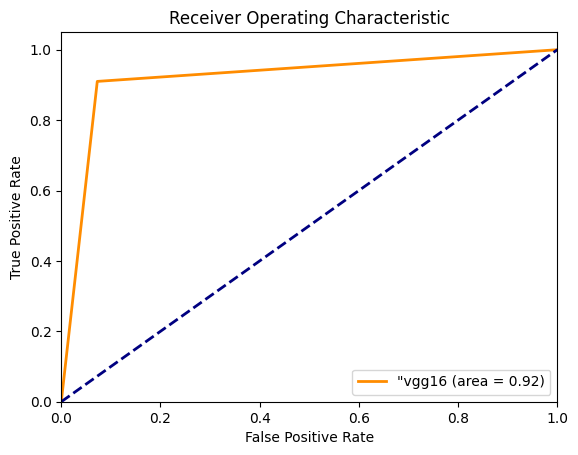

vgg16 roc acc: 0.9187096774193549


In [ ]:
# Create a dictionary to map string labels to integers
label_mapping = {'Healthy': 0, 'Osteoporosis': 1}

# Convert the string labels in y_test to integers
y_test_numeric = [label_mapping[label] for label in y_test]
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder instance
le = LabelEncoder()

# Fit the encoder on the unique labels in y_test
le.fit(y_test.unique())

# Transform the string labels in y_test to integers
y_test_numeric = le.transform(y_test)
from sklearn.metrics import roc_auc_score, roc_curve

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test_numeric, pred)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test_numeric, pred)
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='"vgg16 (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("vgg16 roc acc:", roc_auc)

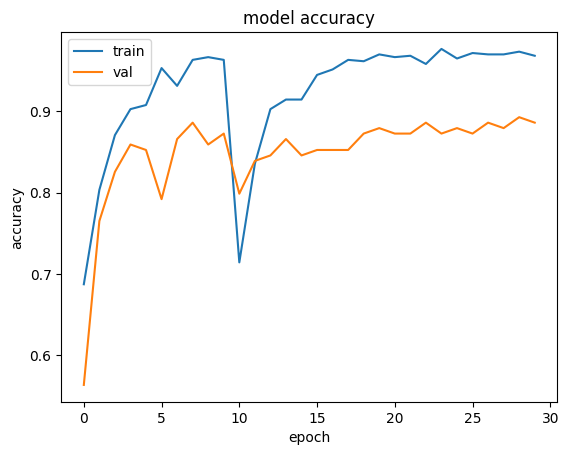

In [ ]:
plt.plot(history1.history["accuracy"]+
         history11.history["accuracy"]+
         history111.history["accuracy"])

plt.plot(
history1.history["val_accuracy"]+
          history11.history["val_accuracy"]+
          history111.history["val_accuracy"]
 )

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

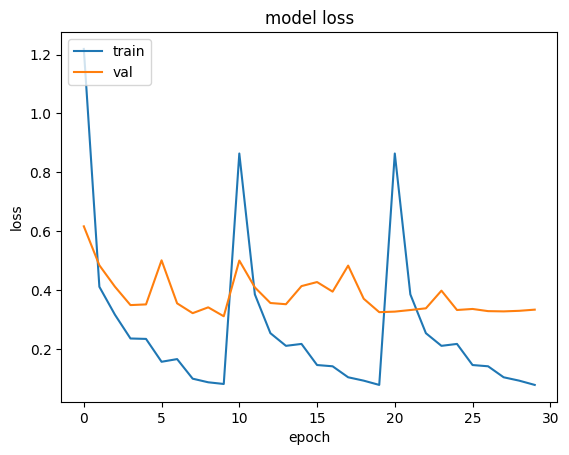

In [ ]:
plt.plot(
history1.history["loss"] +
          history11.history["loss"]+
          history11.history["loss"])


plt.plot(
history1.history["val_loss"]+
          history11.history["val_loss"]+
          history111.history["val_loss"])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

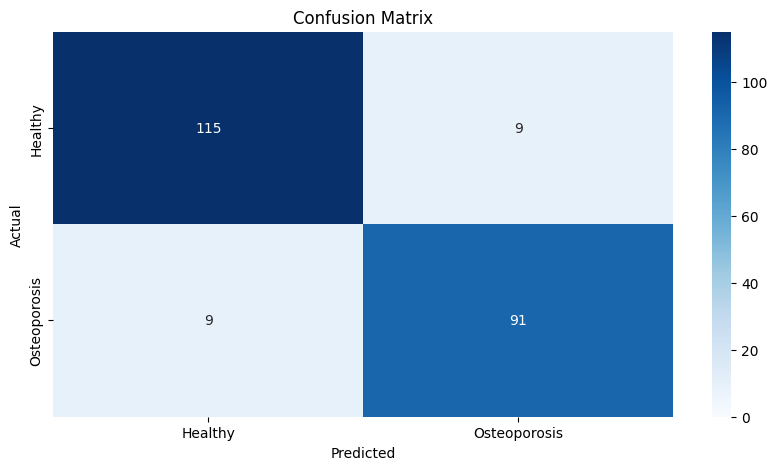

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class labels
class_labels = ['Healthy','Osteoporosis']

# Calculate the confusion matrix
cm = confusion_matrix(y_test, pred2)

# Create a figure and plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

# Set tick labels and axis labels
plt.xticks(ticks=[0.5, 1.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Set the title
plt.title("Confusion Matrix")

# Show the plot
plt.show()


#### **1.2 AlexNet**

In [ ]:
# Importing Keras libraries and packages
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization

In [ ]:
# Initializing the CNN
model = Sequential()
# Convolution Step 1
model.add(Convolution2D(96, 11, strides = (4, 4), padding = 'valid', input_shape=(224, 224, 3), activation = 'relu'))
# Max Pooling Step 1
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
model.add(BatchNormalization())
# Convolution Step 2
model.add(Convolution2D(256, 11, strides = (1, 1), padding='valid', activation = 'relu'))
# Max Pooling Step 2
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding='valid'))
model.add(BatchNormalization())
# Convolution Step 3
model.add(Convolution2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
model.add(BatchNormalization())
# Convolution Step 4
model.add(Convolution2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
model.add(BatchNormalization())
# Convolution Step 5
model.add(Convolution2D(256, 3, strides=(1,1), padding='valid', activation = 'relu'))
# Max Pooling Step 3
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
model.add(BatchNormalization())
# Flattening Step
model.add(Flatten())
# Full Connection Step
model.add(Dense(units = 4096, activation = 'relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(units = 4096, activation = 'relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(units = 1000, activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(units = num_classes, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 96)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 27, 27, 96)        384       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 256)       2973952   
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 256)         0         
 g2D)                                                            
                                                        

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history2 = model.fit(
    train,
    steps_per_epoch=None,
    epochs=15,
    validation_data=val,
    validation_steps=4,
    verbose=1,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],
    shuffle=True)

Epoch 1/15
149/149 [==============================] - 26s 104ms/step - loss: 1.3723 - accuracy: 0.5042 - val_loss: 1.7987 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 2/15
149/149 [==============================] - 14s 95ms/step - loss: 0.9884 - accuracy: 0.4924 - val_loss: 0.7854 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 3/15
149/149 [==============================] - 10s 67ms/step - loss: 0.8535 - accuracy: 0.5580 - val_loss: 2.0871 - val_accuracy: 0.4375 - lr: 0.0010
Epoch 4/15
149/149 [==============================] - 14s 95ms/step - loss: 0.9147 - accuracy: 0.5227 - val_loss: 1.6363 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 5/15
149/149 [==============================] - 20s 133ms/step - loss: 0.8591 - accuracy: 0.5462 - val_loss: 0.7448 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 6/15
149/149 [==============================] - 14s 96ms/step - loss: 0.7874 - accuracy: 0.5664 - val_loss: 0.4366 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 7/15
149/149 [==============================] - 15

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/MyModels/model__Alexnet.h5')

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(val)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
38/38 [==============================] - 3s 89ms/step - loss: 0.7186 - accuracy: 0.5906
Test Accuracy: 59.06040072441101


In [ ]:
results = model.evaluate(test, verbose=1)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

56/56 [==============================] - 5s 98ms/step - loss: 0.7304 - accuracy: 0.5982
    Test Loss: 0.73038
Test Accuracy: 59.82%


In [ ]:
# Predict the label of the test_gen
pred = model.predict(test,verbose=1)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

56/56 [==============================] - 5s 82ms/step


In [ ]:
y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred)*100))

              precision    recall  f1-score   support

     Healthy       0.71      0.47      0.56       124
Osteoporosis       0.54      0.76      0.63       100

    accuracy                           0.60       224
   macro avg       0.62      0.61      0.60       224
weighted avg       0.63      0.60      0.59       224

Accuracy of the Model: 59.8%


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


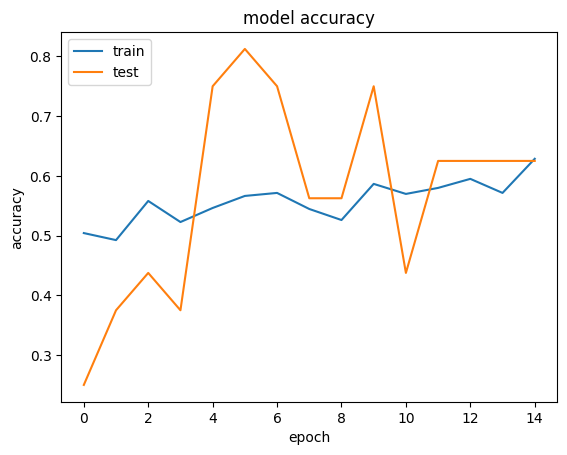

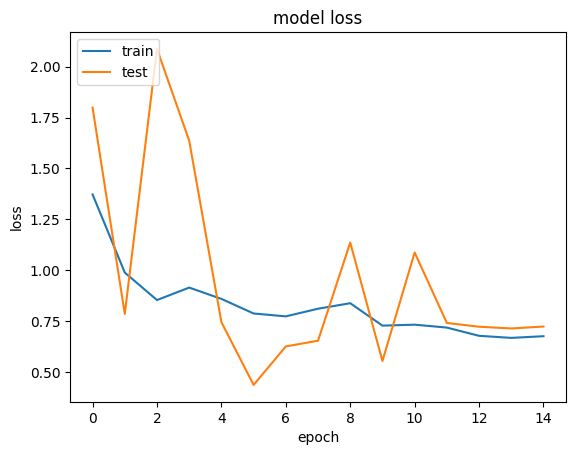

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy

print(history2.history.keys())

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

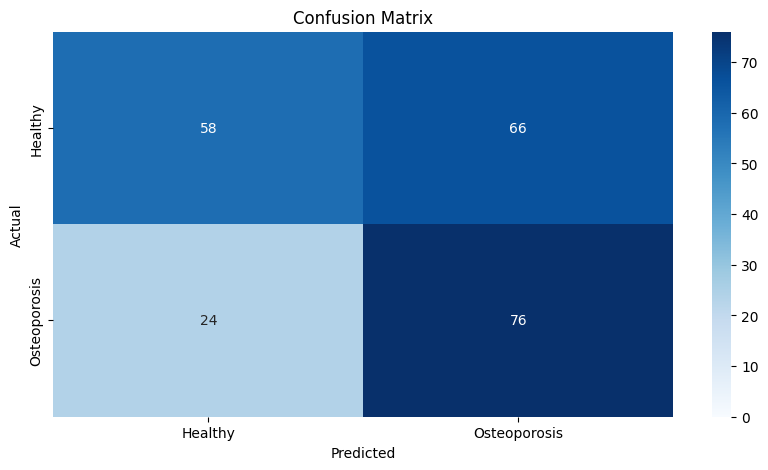

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class labels
class_labels = ['Healthy','Osteoporosis']

# Calculate the confusion matrix
cm = confusion_matrix(y_test, pred)

# Create a figure and plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

# Set tick labels and axis labels
plt.xticks(ticks=[0.5, 1.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Set the title
plt.title("Confusion Matrix")

# Show the plot
plt.show()

#### **1.3. ResNet50 Model**

In [ ]:
from keras.applications import ResNet50



pretrained_model = ResNet50(
    input_shape=(224,224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:

inputs = pretrained_model.input

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dense(128, activation='relu')(x)

outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [ ]:

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
my_callbacks  = [EarlyStopping(monitor='val_loss',min_delta=0,patience=3,mode='auto')]

In [ ]:
history= model.fit(
    train,
    validation_data=val,
    epochs=10,
    callbacks=my_callbacks,
    verbose=1,
    steps_per_epoch=None,
    validation_steps=4
)

Epoch 1/10
149/149 [==============================] - 20s 81ms/step - loss: 0.6972 - accuracy: 0.6134 - val_loss: 0.5799 - val_accuracy: 0.7500
Epoch 2/10
149/149 [==============================] - 12s 77ms/step - loss: 0.5853 - accuracy: 0.6958 - val_loss: 0.5958 - val_accuracy: 0.6875
Epoch 3/10
149/149 [==============================] - 12s 79ms/step - loss: 0.5587 - accuracy: 0.7429 - val_loss: 0.6478 - val_accuracy: 0.5625
Epoch 4/10
149/149 [==============================] - 16s 104ms/step - loss: 0.5404 - accuracy: 0.7361 - val_loss: 0.5241 - val_accuracy: 0.7500
Epoch 5/10
149/149 [==============================] - 10s 70ms/step - loss: 0.5252 - accuracy: 0.7462 - val_loss: 0.5021 - val_accuracy: 0.7500
Epoch 6/10
149/149 [==============================] - 17s 115ms/step - loss: 0.5361 - accuracy: 0.7429 - val_loss: 0.5063 - val_accuracy: 0.7500
Epoch 7/10
149/149 [==============================] - 11s 72ms/step - loss: 0.5275 - accuracy: 0.7395 - val_loss: 0.5163 - val_accurac

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/MyModels/model_resnet50.h5')

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(val)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
38/38 [==============================] - 3s 86ms/step - loss: 0.5494 - accuracy: 0.7315
Test Accuracy: 73.15436005592346


In [ ]:
# Predict the label of the test_gen
pred1 = model.predict(test,verbose=1)
pred1 = np.argmax(pred1,axis=1)

# Map the label
labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred1]

56/56 [==============================] - 6s 111ms/step


In [ ]:
y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred1))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred1)*100))

              precision    recall  f1-score   support

     Healthy       0.97      0.53      0.69       124
Osteoporosis       0.63      0.98      0.77       100

    accuracy                           0.73       224
   macro avg       0.80      0.76      0.73       224
weighted avg       0.82      0.73      0.72       224

Accuracy of the Model: 73.2%


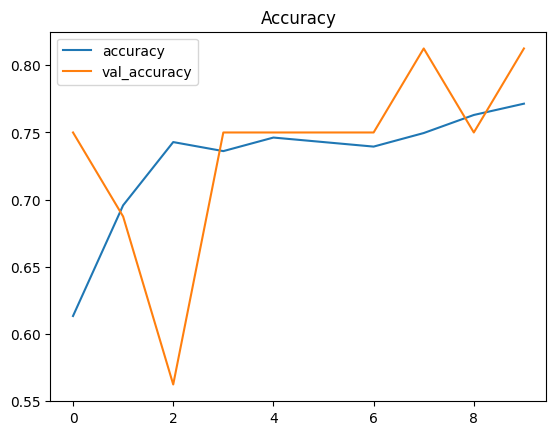

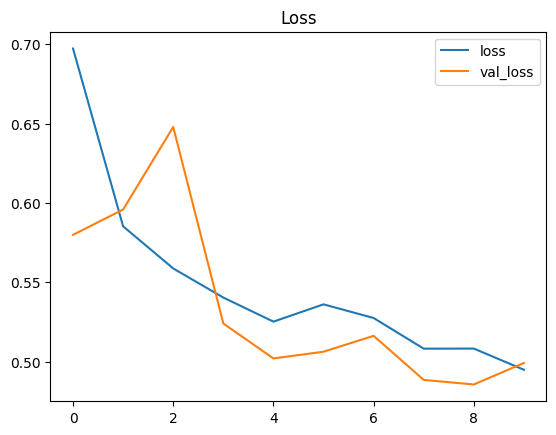

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

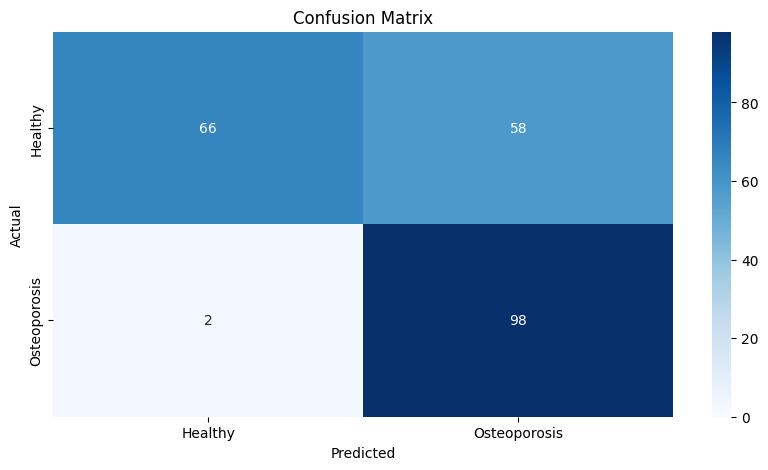

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class labels
class_labels = ['Healthy','Osteoporosis']

# Calculate the confusion matrix
cm = confusion_matrix(y_test, pred1)

# Create a figure and plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

# Set tick labels and axis labels
plt.xticks(ticks=[0.5, 1.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Set the title
plt.title("Confusion Matrix")

# Show the plot
plt.show()

#### **1.4. VGG19 Modeli**

In [ ]:
def create_Base_model_from_VGG19():
    model_vgg19 = VGG19(
        weights = "imagenet",# control point from which model is started
        include_top=False, # to include/exclude the first 3 layers
        input_shape = (224,224, 3)) # image size
    # don't train existing weights
    for layer in model_vgg19.layers:
      layer.trainable = False
    return model_vgg19
create_Base_model_from_VGG19().summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
def add_custom_layers_vgg19():
    #Adding custom Layers
    model_vgg19 = create_Base_model_from_VGG19()
    x = model_vgg19.output
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    predictions = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    # creating the final model
    final_model = tf.keras.models.Model(
        inputs = model_vgg19.input,
        outputs = predictions)

    final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return final_model

add_custom_layers_vgg19().summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
model_from_vgg19 = add_custom_layers_vgg19()
history4 = model_from_vgg19.fit(train,
                      steps_per_epoch=None,
                      epochs=10,
                      validation_data=val,
                      validation_steps=None,
                      verbose=1,
                      callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],
                      use_multiprocessing=False,
                      shuffle=True)

Epoch 1/10
149/149 [==============================] - 15s 93ms/step - loss: 0.9608 - accuracy: 0.6975 - val_loss: 0.4690 - val_accuracy: 0.7718 - lr: 0.0010
Epoch 2/10
149/149 [==============================] - 13s 89ms/step - loss: 0.4084 - accuracy: 0.8387 - val_loss: 0.5253 - val_accuracy: 0.7785 - lr: 0.0010
Epoch 3/10
149/149 [==============================] - 13s 89ms/step - loss: 0.2866 - accuracy: 0.8857 - val_loss: 0.3879 - val_accuracy: 0.8188 - lr: 0.0010
Epoch 4/10
149/149 [==============================] - 13s 87ms/step - loss: 0.2346 - accuracy: 0.9109 - val_loss: 0.4054 - val_accuracy: 0.8389 - lr: 0.0010
Epoch 5/10
149/149 [==============================] - 14s 96ms/step - loss: 0.1793 - accuracy: 0.9345 - val_loss: 0.8631 - val_accuracy: 0.7114 - lr: 0.0010
Epoch 6/10
149/149 [==============================] - 13s 88ms/step - loss: 0.2397 - accuracy: 0.8941 - val_loss: 0.3606 - val_accuracy: 0.8792 - lr: 0.0010
Epoch 7/10
149/149 [==============================] - 13s 

In [ ]:
model_from_vgg19.evaluate(test, verbose=1)

56/56 [==============================] - 7s 127ms/step - loss: 0.3183 - accuracy: 0.8884


[0.31828346848487854, 0.8883928656578064]

In [ ]:
model_from_vgg19 = add_custom_layers_vgg19()
history44 = model_from_vgg19.fit(train,
                      steps_per_epoch=None,
                      epochs=10,
                      validation_data=val,
                      validation_steps=None,
                      verbose=1,
                      callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],
                      use_multiprocessing=False,
                      shuffle=True)

Epoch 1/10
149/149 [==============================] - 15s 91ms/step - loss: 1.1934 - accuracy: 0.7378 - val_loss: 0.8383 - val_accuracy: 0.7181 - lr: 0.0010
Epoch 2/10
149/149 [==============================] - 13s 90ms/step - loss: 0.4746 - accuracy: 0.8017 - val_loss: 0.4359 - val_accuracy: 0.8389 - lr: 0.0010
Epoch 3/10
149/149 [==============================] - 16s 107ms/step - loss: 0.2635 - accuracy: 0.8958 - val_loss: 0.7346 - val_accuracy: 0.6980 - lr: 0.0010
Epoch 4/10
149/149 [==============================] - 13s 89ms/step - loss: 0.2689 - accuracy: 0.8992 - val_loss: 0.3540 - val_accuracy: 0.8591 - lr: 0.0010
Epoch 5/10
149/149 [==============================] - 13s 90ms/step - loss: 0.2064 - accuracy: 0.9160 - val_loss: 0.5140 - val_accuracy: 0.7852 - lr: 0.0010
Epoch 6/10
149/149 [==============================] - 13s 89ms/step - loss: 0.1577 - accuracy: 0.9462 - val_loss: 0.4273 - val_accuracy: 0.8792 - lr: 0.0010
Epoch 7/10
149/149 [==============================] - 13s

In [ ]:
model_from_vgg19.evaluate(test, verbose=1)

56/56 [==============================] - 8s 134ms/step - loss: 0.3099 - accuracy: 0.8929


[0.3098960220813751, 0.8928571343421936]

In [ ]:
model_from_vgg19 = add_custom_layers_vgg19()
history444 = model_from_vgg19.fit(train,
                      steps_per_epoch=None,
                      epochs=10,
                      validation_data=val,
                      validation_steps=None,
                      verbose=1,
                      callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],
                      use_multiprocessing=False,
                      shuffle=True)

Epoch 1/10
149/149 [==============================] - 18s 101ms/step - loss: 0.9763 - accuracy: 0.7277 - val_loss: 0.5957 - val_accuracy: 0.7584 - lr: 0.0010
Epoch 2/10
149/149 [==============================] - 13s 88ms/step - loss: 0.4330 - accuracy: 0.8168 - val_loss: 0.4346 - val_accuracy: 0.8188 - lr: 0.0010
Epoch 3/10
149/149 [==============================] - 13s 90ms/step - loss: 0.3110 - accuracy: 0.8807 - val_loss: 0.5611 - val_accuracy: 0.7517 - lr: 0.0010
Epoch 4/10
149/149 [==============================] - 13s 89ms/step - loss: 0.2662 - accuracy: 0.9008 - val_loss: 0.4780 - val_accuracy: 0.7785 - lr: 0.0010
Epoch 5/10
149/149 [==============================] - 15s 97ms/step - loss: 0.2575 - accuracy: 0.8975 - val_loss: 0.6083 - val_accuracy: 0.6510 - lr: 0.0010
Epoch 6/10
149/149 [==============================] - 13s 90ms/step - loss: 0.1724 - accuracy: 0.9277 - val_loss: 0.4170 - val_accuracy: 0.8255 - lr: 3.0000e-04
Epoch 7/10
149/149 [==============================] -

In [ ]:
model_from_vgg19.evaluate(test, verbose=1)

56/56 [==============================] - 7s 125ms/step - loss: 0.2665 - accuracy: 0.9062


[0.266529381275177, 0.90625]

In [ ]:
model_from_vgg19.save('/content/drive/MyDrive/Colab Notebooks/Model/plant_disease_VGG19.h5')

In [ ]:
pred = model_from_vgg19.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred3= [labels[k] for k in pred]

56/56 [==============================] - 6s 100ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred3))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred3)*100))

              precision    recall  f1-score   support

     Healthy       0.93      0.78      0.85       124
Osteoporosis       0.78      0.93      0.85       100

    accuracy                           0.85       224
   macro avg       0.85      0.86      0.85       224
weighted avg       0.86      0.85      0.85       224

Accuracy of the Model: 84.8%


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

# Convert labels to one-hot encoded format
lb = LabelBinarizer()
lb.fit(y_test)
y_test_one_hot = lb.transform(y_test)
pred_one_hot = lb.transform(pred3)

# Compute micro-averaged ROC-AUC score
roc_auc = roc_auc_score(y_test_one_hot, pred_one_hot, average='micro')

print("Micro-Averaged ROC-AUC Score:", roc_auc)


Micro-Averaged ROC-AUC Score: 0.8561290322580646


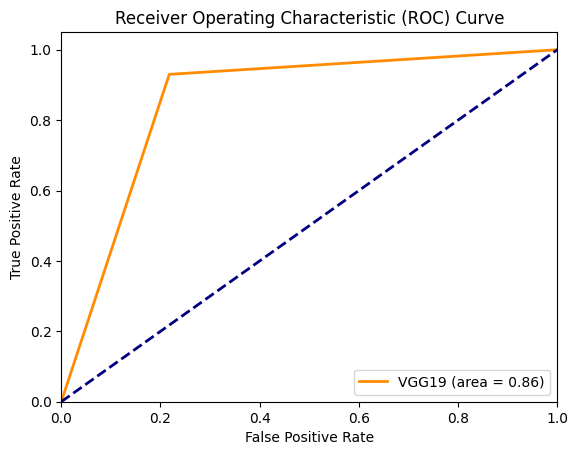

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test_one_hot.ravel(), pred_one_hot.ravel())

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='VGG19 (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


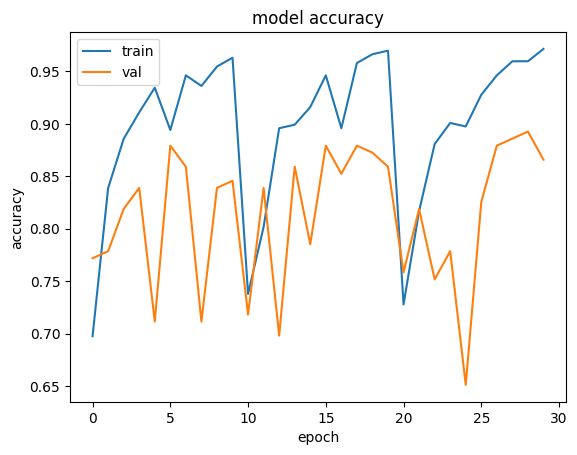

In [ ]:
plt.plot(history4.history["accuracy"]+
         history44.history["accuracy"]+
         history444.history["accuracy"])

plt.plot(
history4.history["val_accuracy"]+
          history44.history["val_accuracy"]+
          history444.history["val_accuracy"]
 )

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

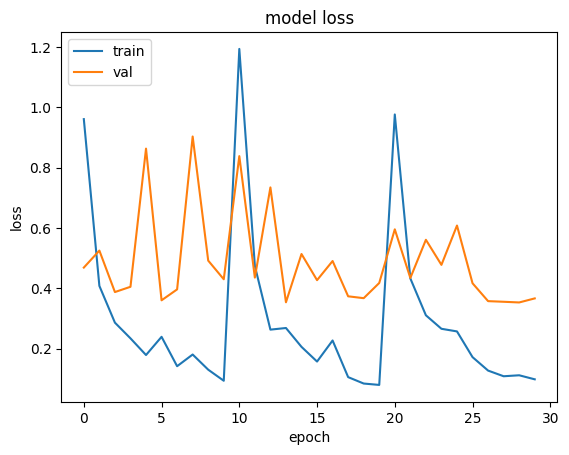

In [ ]:
plt.plot(
history4.history["loss"] +
          history44.history["loss"]+
          history444.history["loss"])


plt.plot(
history4.history["val_loss"]+
          history44.history["val_loss"]+
          history444.history["val_loss"])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

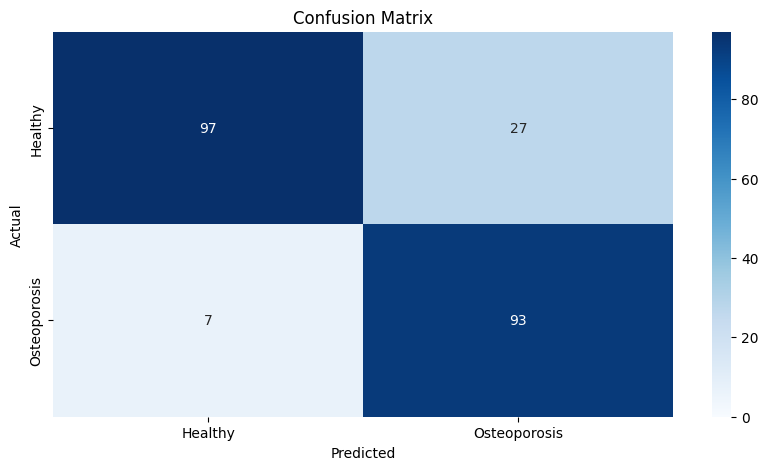

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class labels
class_labels = ['Healthy','Osteoporosis']

# Calculate the confusion matrix
cm = confusion_matrix(y_test, pred3)

# Create a figure and plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

# Set tick labels and axis labels
plt.xticks(ticks=[0.5, 1.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Set the title
plt.title("Confusion Matrix")

# Show the plot
plt.show()

###VGG16 PREDICT

In [ ]:
import numpy as np
from keras.models import load_model
from keras.preprocessing import image
model_vgg16=load_model('/content/drive/MyDrive/Colab Notebooks/Model/model_VGG16.h5')

1/1 [==============================] - 1s 1s/step
Healthy


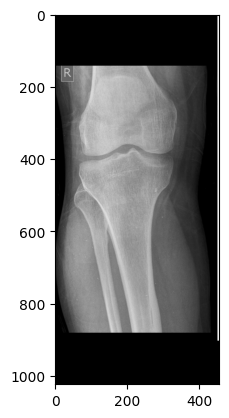

In [ ]:
classes=list(train.class_indices.keys())
# Pre-Processing test data same as train data.
def prepare(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)

img_url='/content/drive/MyDrive/Colab Notebooks/Osteoporosis/N/N (1).JPEG'
result_vgg16 = model_vgg16.predict([prepare(img_url)])
disease=image.load_img(img_url)
plt.imshow(disease)

classresult=np.argmax(result_vgg16,axis=1)
print(classes[classresult[0]])

###VGG19 PREDICT

In [ ]:
import numpy as np
from keras.models import load_model
from keras.preprocessing import image
model_vgg19=load_model('/content/drive/MyDrive/Colab Notebooks/Model/plant_disease_VGG19.h5')

1/1 [==============================] - 0s 282ms/step
Osteoporosis


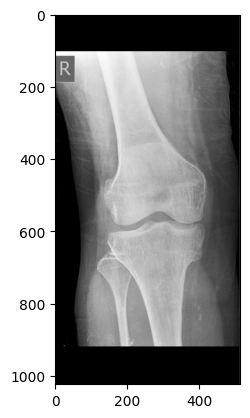

In [ ]:
classes=list(train.class_indices.keys())
# Pre-Processing test data same as train data.
def prepare(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)

img_url='/content/drive/MyDrive/Colab Notebooks/Osteoporosis/O/O (2).JPEG'
result_vgg19 = model_vgg19.predict([prepare(img_url)])
disease=image.load_img(img_url)
plt.imshow(disease)

classresult=np.argmax(result_vgg19,axis=1)
print(classes[classresult[0]])